In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

### Cargamos el dataset

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df['Pclass'] = df.Pclass.astype(object)

Eliminamos las columnas que no son predicturas

In [4]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

Creamos cageogoricas

In [5]:
df = pd.get_dummies(df, drop_first=True)

In [6]:
df['Age'] = df['Age'].fillna(df.Age.mean())


### Crea una regresion logistica

In [8]:
target = 'Survived'
X = df.drop(columns=target)
y = df[target]

model = linear_model.LogisticRegression().fit(X, y)
probabilities = model.predict_proba(X)[:]

p1 = [i[1] for i in probabilities]

### Concepto odds

Mi equipo gana 1 a 4


In [9]:
1 / 4

0.25

Probabilidad de ganar 

In [10]:
1 / (1+4)

0.2

Probabilidad perder

In [11]:
 1- (1 / (1+4))

0.8

Mi equipo gana 5 a 3

In [12]:
5/3

1.6666666666666667

Probabilidad que equipo gane 

In [15]:
5/(5+3)

0.625

Probabilidd de perder

In [16]:
1 - 5/(5+3)

0.375

¿Qué pasa si divido la probabilidad de ganar entre la probabiliad de perder?

In [18]:
p = (5 / (5+3))

p/(1-p)

1.6666666666666667

$$odds = \frac{p}{1-p}$$

Calcula los odds de las predicciones del modelo

In [20]:
odds_titanic = [i / (1-i) for i in p1]

Los odds pueden llegar a ser muy volatiles, pon el histograma

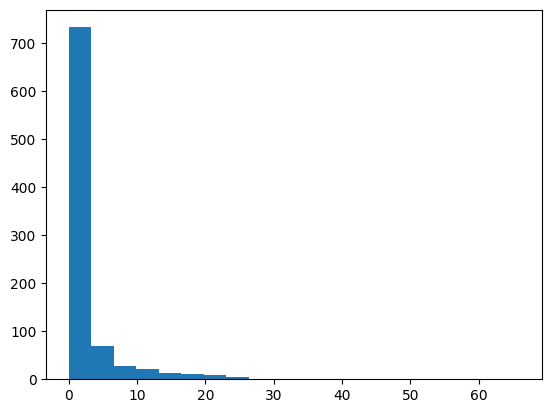

In [22]:
plt.hist(odds_titanic, bins=20)
plt.show()

$$log(odds) = log(\frac{p}{1-p})$$

Pero el log odds no es tan disperso, histograma del log odds

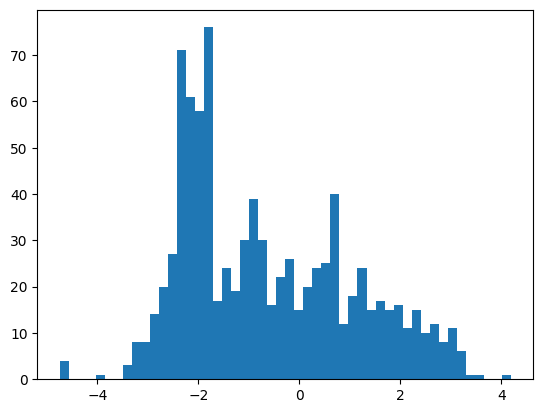

In [24]:
log_odds_titanic = np.log(odds_titanic)
plt.hist(log_odds_titanic, bins=50)
plt.show()

### ¿Y esto que? 

Si tomamos los coeficientes de una regresión logistica como si gura una regresión lineal, obtenemos un numero extraño

$$z = \Theta ^T X $$



In [27]:
# Calcula Z
z = (model.coef_ * X).sum(axis=1) + model.intercept_

Resulta ser que z es lo mismo que log odds

In [29]:
verdad = pd.DataFrame({
    'z':z,
    'log_odds':log_odds_titanic
})
verdad.head()

,z,log_odds
0,-2.291960,-2.291960
1,2.285322,2.285322
2,0.463447,0.463447
3,1.869217,1.869217
4,-2.445576,-2.445576


In [30]:
coeficientes = pd.DataFrame({
    'Features':X.keys(),
    'Coeficientes':model.coef_[0]
})
coeficientes

,Features,Coeficientes
0,Age,-0.036217
1,SibSp,-0.314514
2,Parch,-0.089098
3,Fare,0.003357
4,Pclass_2,-0.718025
5,Pclass_3,-1.894593
6,Sex_male,-2.583493
7,Embarked_Q,-0.058762
8,Embarked_S,-0.463718


### Esto es importante porque de aquí sale sigmoide

$$log(\frac{p}{1-p}) = \Theta ^T X$$


Aplicamos la exponencial en ambos lados:

$$
e^{\Theta ^T X} = \frac{p}{1 - p}
$$

Despejamos \( p \):

$$
p = \frac{e^{\Theta ^T X}}{1 + e^{\Theta ^T X}}
$$

Simplificando

$$
p= \frac{1}{1 + e^{\Theta ^T X}}
$$

Comprobando

### _Comprobamos que Sklearn opera conforme a la teoría_ 

### Comparando diferentes tipos de regresiones

#### Regresion logistica


In [31]:
target = 'Survived'

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = linear_model.LogisticRegression().fit(X_train, y_train)
probabilidades_modelo1 = model.predict_proba(X_test)[:, 1]

#### Checando los coeficientes

In [3]:
## Checa los coeficientes, que significan?


  #### Regresion logistica polinomial 2


In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('model', linear_model.LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)
probabilidades_modelo2 = pipeline.predict_proba(X_test)[:,1]

#### Polinomio grado 3

In [36]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=3)),
    ('model', linear_model.LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)
probabilidades_modelo3 = pipeline.predict_proba(X_test)[:,1]

#### Analisis del discriminante lineal 

In [37]:
from sklearn import discriminant_analysis


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)
probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:,1]


### Junta los datasets

In [38]:
juntar = pd.DataFrame({
    'real':y_test,
    'logistica1':probabilidades_modelo1,
    'logistica2':probabilidades_modelo2,
    'logistica3':probabilidades_modelo3,
    'probabilidades_disc':probabilidades_modelo_disc
})
juntar.head()

,real,logistica1,logistica2,logistica3,probabilidades_disc
495,0,0.154929,0.186737,2.131844e-01,0.094228
648,0,0.104622,0.124614,1.369800e-01,0.056745
278,0,0.076536,0.011373,2.245031e-07,0.066734
31,1,0.933829,0.993344,9.999965e-01,0.971403
255,1,0.691419,0.647217,9.840537e-01,0.741915


In [39]:
# Bins
bins = 5

juntar['bins_log1'] = pd.qcut(juntar['logistica1'], q=bins, labels=False) + 1
juntar['bins_log2'] = pd.qcut(juntar['logistica2'], q=bins, labels=False) + 1
juntar['bins_log3'] = pd.qcut(juntar['logistica3'], q=bins, labels=False) + 1
juntar['bins_disc'] = pd.qcut(juntar['probabilidades_disc'], q=bins, labels=False) + 1

# Agrupaciones
grouped_log1 = juntar.groupby('bins_log1').mean()
grouped_log2 = juntar.groupby('bins_log2').mean()
grouped_log3 = juntar.groupby('bins_log3').mean()
grouped_disc = juntar.groupby('bins_disc').mean()


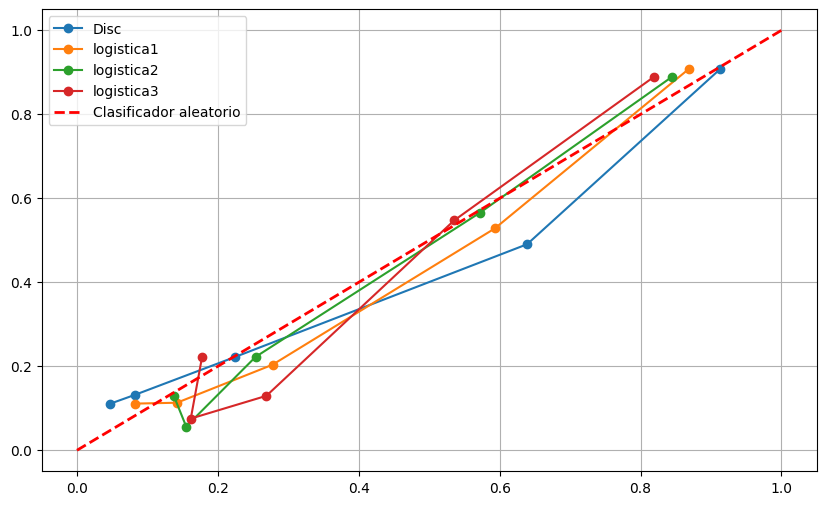

In [44]:
## Grafico de modelos
plt.figure(figsize=(10,6))
plt.plot(grouped_disc.probabilidades_disc, grouped_disc.real, marker='o', label='Disc')
plt.plot(grouped_log1.logistica1,grouped_log1.real, marker='o', label='logistica1')
plt.plot(grouped_log2.logistica1,grouped_log2.real, marker='o', label='logistica2')
plt.plot(grouped_log3.logistica1,grouped_log3.real, marker='o', label='logistica3')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()
plt.grid()


¿Cuál es mejor? Veamos la función de perdida en el conjunto de prueba

$$
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$

In [45]:
from sklearn.metrics import log_loss

Modelo logistico

In [46]:
log_loss(y_pred = juntar['logistica1'], y_true=juntar['real'])

0.4438617895366866

Modelo polinomio 2

In [47]:
log_loss(y_pred = juntar['logistica2'], y_true=juntar['real'])

0.4350031665635819

Modelo polinomio 3

In [48]:
log_loss(y_pred = juntar['logistica3'], y_true=juntar['real'])

0.6811829425749643

Modelo discriminante

In [49]:
log_loss(y_pred=juntar['probabilidades_disc'], y_true=juntar.real)

0.4469248818517998

#### Histogramas

#### Logistica

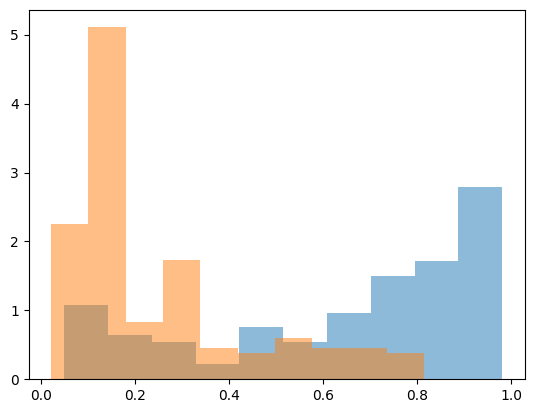

In [52]:
plt.hist(juntar.query('real == 1').logistica1, density=True, alpha=0.5)
plt.hist(juntar.query('real == 0').logistica1, density=True, alpha=0.5)
plt.show()

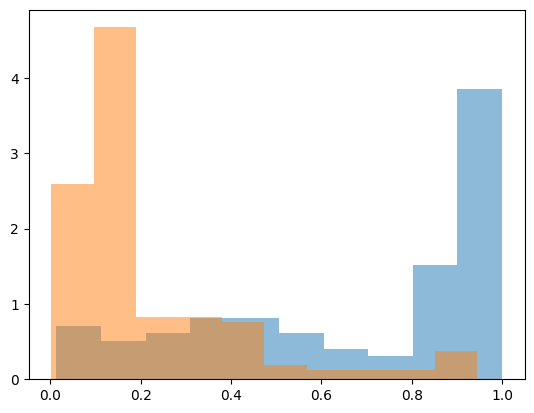

In [53]:
plt.hist(juntar.query('real == 1').logistica2, density=True, alpha=0.5)
plt.hist(juntar.query('real == 0').logistica2, density=True, alpha=0.5)
plt.show()

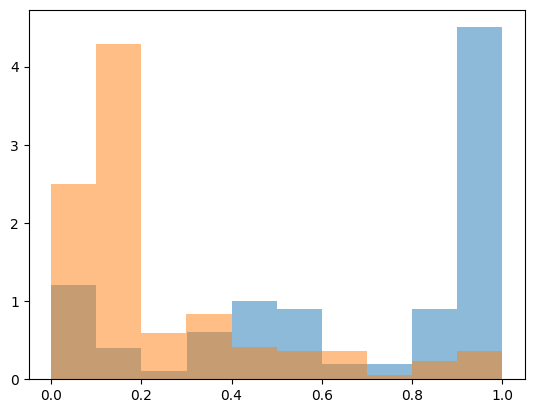

In [54]:
plt.hist(juntar.query('real == 1').logistica3, density=True, alpha=0.5)
plt.hist(juntar.query('real == 0').logistica3, density=True, alpha=0.5)
plt.show()

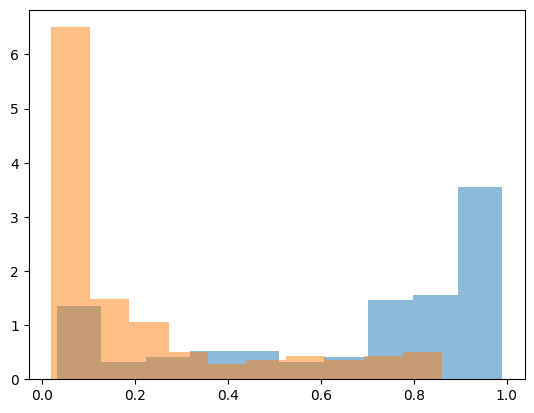

In [55]:
plt.hist(juntar.query('real == 1')['probabilidades_disc'], density=True, alpha=0.5)
plt.hist(juntar.query('real == 0')['probabilidades_disc'], density=True, alpha=0.5)
plt.show()